In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
energy = pd.read_csv(r'C:\Users\sarva\Desktop\energy_forecasting_pro\data\raw\PJME_hourly.csv')
temp = pd.read_csv(r'C:\Users\sarva\Desktop\energy_forecasting_pro\data\raw\temperature.csv')

In [3]:
energy['Datetime'] = pd.to_datetime(energy['Datetime'])
temp['datetime'] = pd.to_datetime(temp['datetime'])

In [4]:
print("--- Energy Missing ---")
print(energy.isnull().sum())
print("\n--- Temperature (Philadelphia) Missing ---")
print(temp['Philadelphia'].isnull().sum())

--- Energy Missing ---
Datetime    0
PJME_MW     0
dtype: int64

--- Temperature (Philadelphia) Missing ---
3


In [5]:
energy = energy.sort_values('Datetime')
time_diffs = energy['Datetime'].diff().value_counts()
print("\n--- Energy Time Intervals (Gap Analysis) ---")
print(time_diffs)


--- Energy Time Intervals (Gap Analysis) ---
Datetime
0 days 01:00:00    145331
0 days 02:00:00        30
0 days 00:00:00         4
Name: count, dtype: int64


In [6]:
philly_temp = temp[['datetime', 'Philadelphia']].rename(columns={'datetime': 'Datetime', 'Philadelphia': 'Temp'})
analysis_df = pd.merge(energy, philly_temp, on='Datetime', how='inner')
analysis_df['Temp_C'] = analysis_df['Temp'] - 273.15

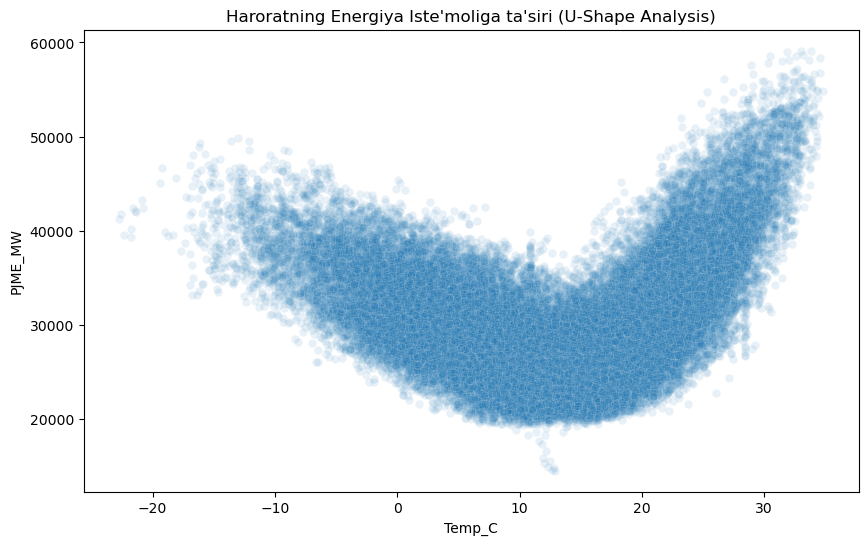

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_df, x='Temp_C', y='PJME_MW', alpha=0.1)
plt.title('Haroratning Energiya Iste\'moliga ta\'siri (U-Shape Analysis)')
plt.show()

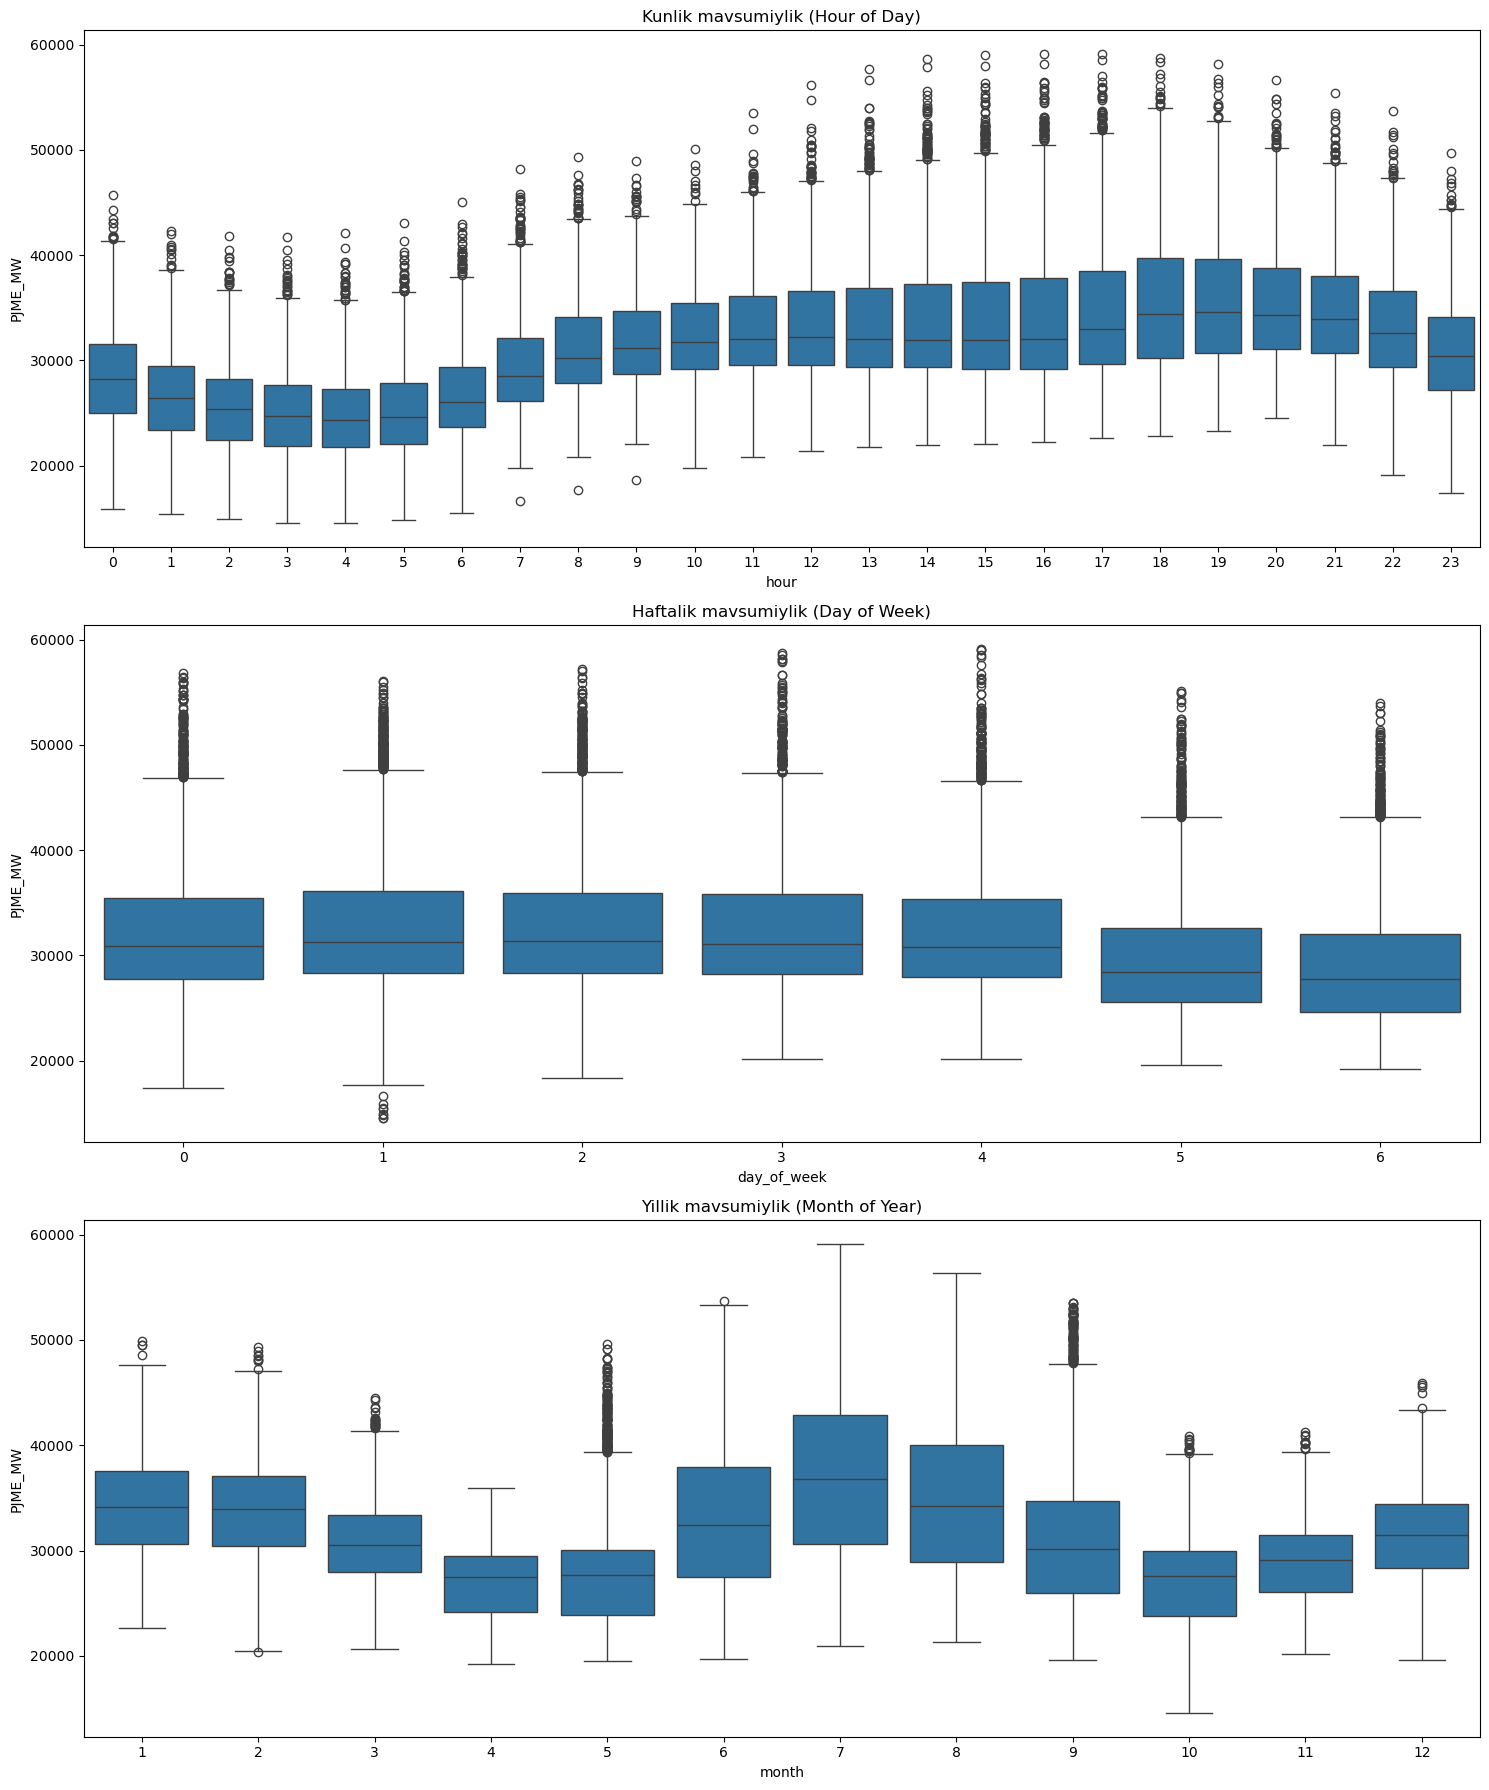

In [8]:
analysis_df['hour'] = analysis_df['Datetime'].dt.hour
analysis_df['day_of_week'] = analysis_df['Datetime'].dt.dayofweek
analysis_df['month'] = analysis_df['Datetime'].dt.month

fig, axes = plt.subplots(3, 1, figsize=(15, 18))

sns.boxplot(data=analysis_df, x='hour', y='PJME_MW', ax=axes[0])
axes[0].set_title('Kunlik mavsumiylik (Hour of Day)')

sns.boxplot(data=analysis_df, x='day_of_week', y='PJME_MW', ax=axes[1])
axes[1].set_title('Haftalik mavsumiylik (Day of Week)')

sns.boxplot(data=analysis_df, x='month', y='PJME_MW', ax=axes[2])
axes[2].set_title('Yillik mavsumiylik (Month of Year)')

plt.tight_layout()
plt.show()

Notebook faylingizning eng yuqori qismiga (Header) loyihaning mazmuni va "diagnostikasi"ni ko'rsatuvchi quyidagi professional xulosani joylashtiring. Bu nafaqat tahlilni tartiblaydi, balki loyihani boshqalarga ko'rsatganda (portfolio uchun) juda tushunarli bo'ladi.

---

# 📊 Smart Grid Energy Forecasting: Data Analysis Summary

## 📌 1. Ma'lumotlar Umumiy Tavsifi

* **Energy Dataset (PJME):** 145,366 soatbay yozuv (2002-2018).
* **Weather Dataset (Temperature):** Philadelphia shahri uchun harorat (2012-2017).
* **Target Variable:** `PJME_MW` (Elektr iste'moli - Megavattlarda).

---

## 🔍 2. Aniqlangan Muammolar va Kamchiliklar (Data Issues)

| Holat | Icon | Tavsif |
| --- | --- | --- |
| **Vaqt Mosligi** | ⏳ | Ikkala dataset faqat **2012-2017** yillar oralig'ida kesishadi (45,250 qator). |
| **Bo'shliqlar** | 🕳️ | Harorat ustunida **3 ta** `NaN` qiymat bor. |
| **Vaqt Uzilishlari** | ⚡ | Iste'mol ma'lumotlarida **34 ta** vaqt sakrashi (gaps) aniqlandi. |
| **Birlar** | 🌡️ | Harorat **Kelvin**da berilgan. Uni tahlil uchun Selsiyga o'tkazish lozim. |

---

## 📈 3. Iste'molning Tabiatini Tushunish (Insights)

* **🔄 Mavsumiylik:** Iste'mol 24 soatlik (Daily) va 7 kunlik (Weekly) qat'iy sikllarga ega.
* **📉 Non-Linearity:** Harorat va iste'mol bog'liqligi **U-shaklida**. Ya'ni, o'ta sovuq () va o'ta issiq () ob-havoda iste'mol keskin oshadi.
* **🏢 Ish Kunlari:** Dushanba-Juma kunlari iste'mol dam olish kunlariga nisbatan sezilarli darajada yuqori.

---

## 🛠️ 4. Keyingi Qadamlar (Action Plan)

1. **Data Cleaning:** Vaqt uzilishlarini va `NaN`larni **Forward Fill** orqali to'ldirish.
2. **Merging:** Ikkala ma'lumotni vaqt bo'yicha qat'iy birlashtirish.
3. **Feature Engineering:**
* 📅 `Calendar features` (Hour, Month, Holiday).
* 🧊 `Lag features` (O'tgan soat va o'tgan haftadagi iste'mol).
* 🔥 `Weather features` (Temp, Temp²).


4. **Validation:** Ma'lumotni random qilmasdan, vaqt bo'yicha qat'iy bo'lish (**Time Series Split**).



In [10]:
df = pd.read_csv('../data/combined/combined_data.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

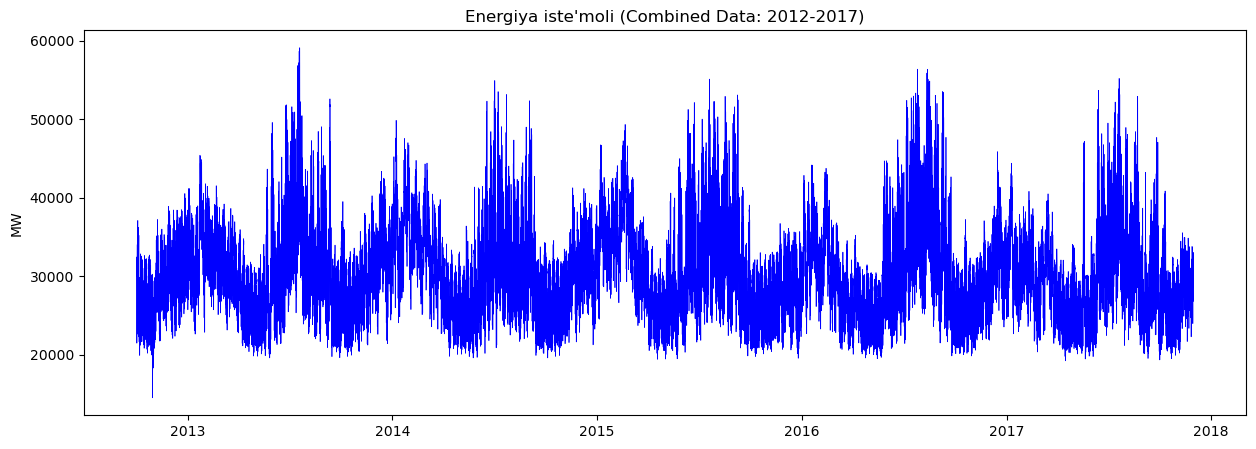

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], df['PJME_MW'], color='blue', linewidth=0.5)
plt.title('Energiya iste\'moli (Combined Data: 2012-2017)')
plt.ylabel('MW')
plt.show()

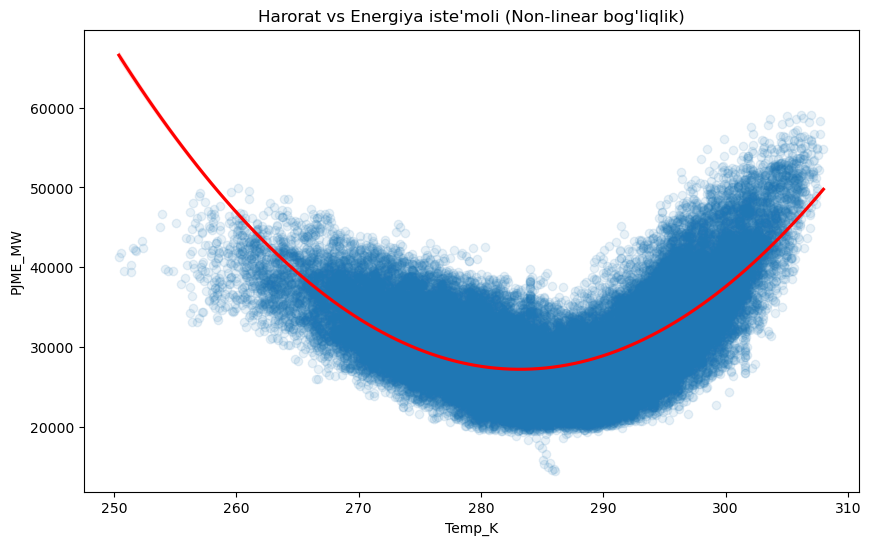

In [12]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Temp_K', y='PJME_MW', 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
plt.title('Harorat vs Energiya iste\'moli (Non-linear bog\'liqlik)')
plt.show()

<Figure size 1200x600 with 0 Axes>

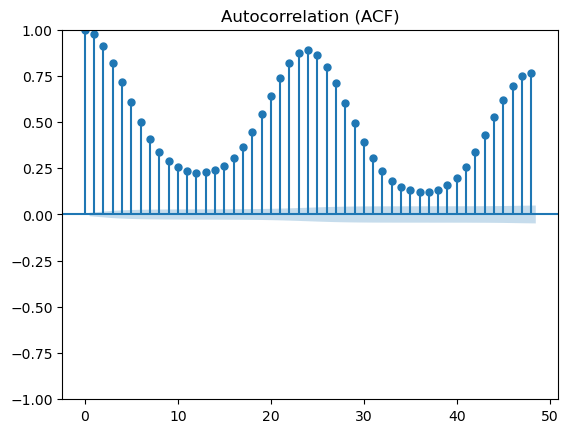

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['PJME_MW'], lags=48) # Oxirgi 48 soatni ko'ramiz
plt.title('Autocorrelation (ACF)')
plt.show()

C:\Users\sarva\AppData\Local\Temp\ipykernel_22536\1944747549.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', ax=ax[0], palette='viridis')
C:\Users\sarva\AppData\Local\Temp\ipykernel_22536\1944747549.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', ax=ax[1], palette='magma')


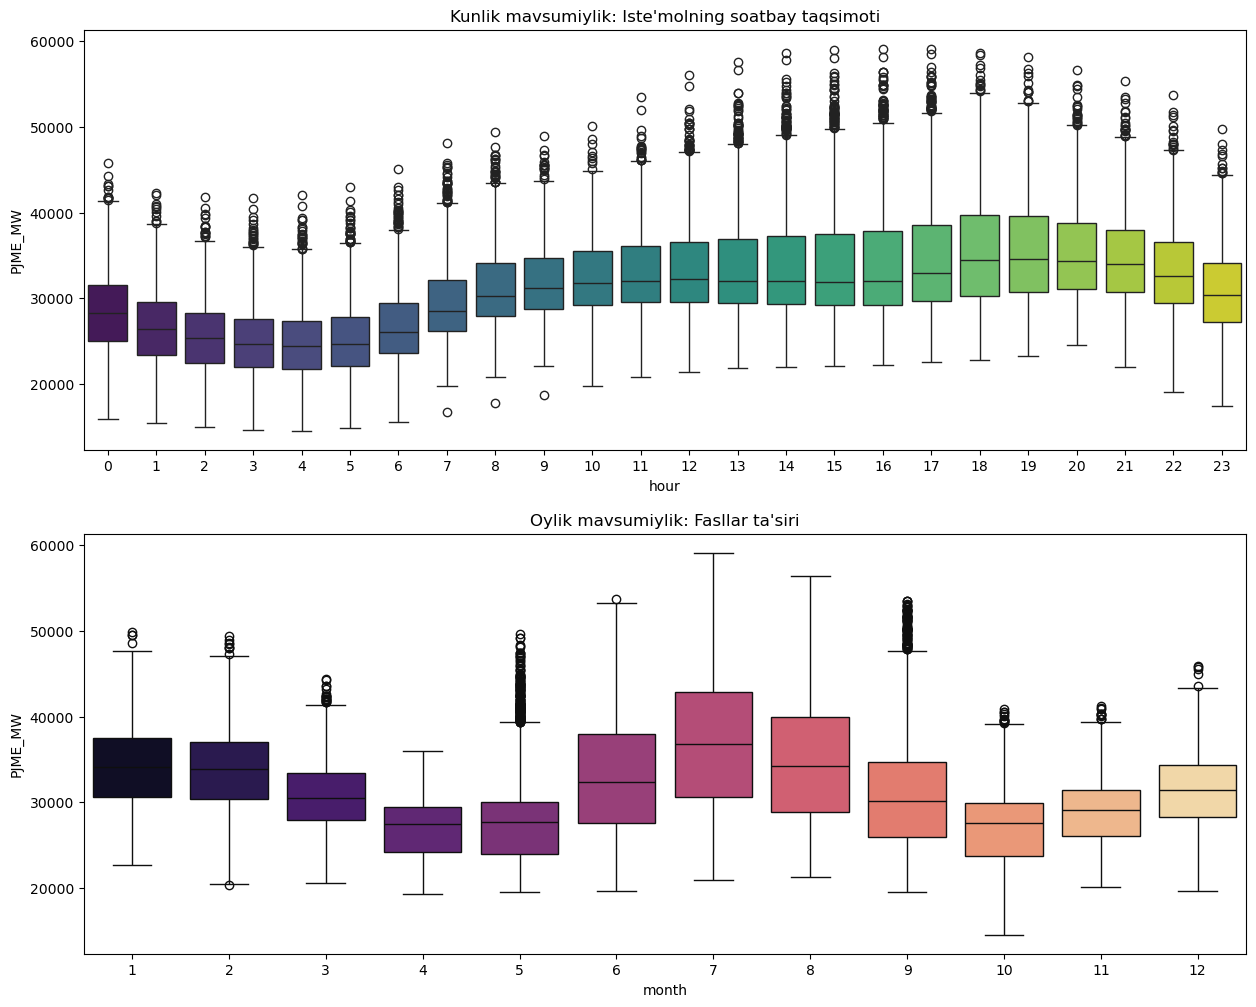

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/combined/combined_data.csv', parse_dates=['Datetime'])
df['hour'] = df['Datetime'].dt.hour
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month

fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Soatbay iste'mol (Kunlik ritm)
sns.boxplot(data=df, x='hour', y='PJME_MW', ax=ax[0], palette='viridis')
ax[0].set_title('Kunlik mavsumiylik: Iste\'molning soatbay taqsimoti')

# Oylik iste'mol (Yillik ritm)
sns.boxplot(data=df, x='month', y='PJME_MW', ax=ax[1], palette='magma')
ax[1].set_title('Oylik mavsumiylik: Fasllar ta\'siri')
plt.show()

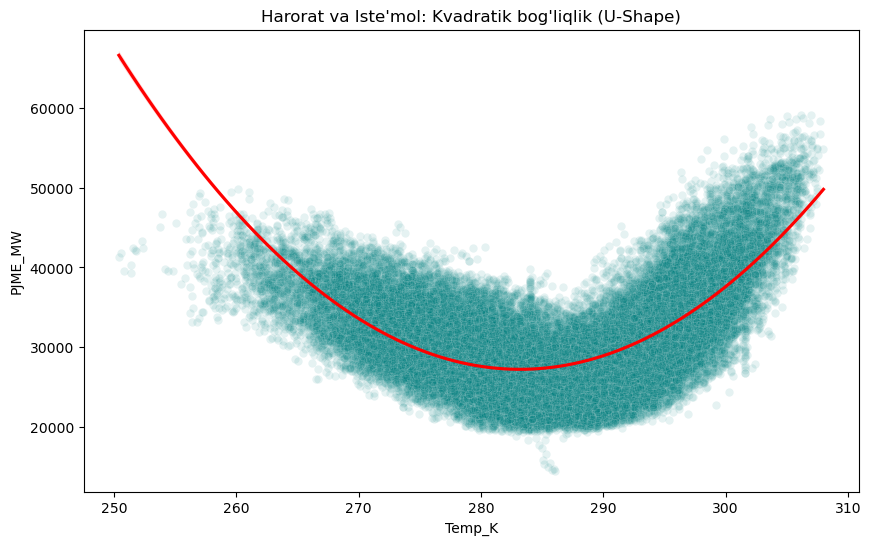

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Temp_K', y='PJME_MW', alpha=0.1, color='teal')
# Polynomial trend line (order=2) kvadratik bog'liqlikni ko'rsatadi
sns.regplot(data=df, x='Temp_K', y='PJME_MW', scatter=False, color='red', order=2)
plt.title('Harorat va Iste\'mol: Kvadratik bog\'liqlik (U-Shape)')
plt.show()

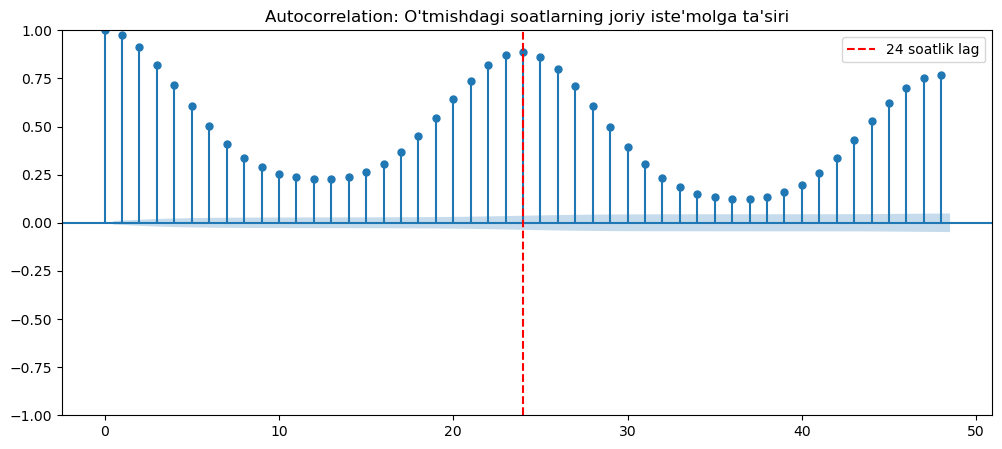

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 5))
plot_acf(df['PJME_MW'], lags=48, ax=plt.gca())
plt.axvline(24, color='red', linestyle='--', label='24 soatlik lag')
plt.title('Autocorrelation: O\'tmishdagi soatlarning joriy iste\'molga ta\'siri')
plt.legend()
plt.show()

In [6]:
# Iste'molning statistik dumi
print("Ekstremal past qiymatlar:\n", df.nsmallest(5, 'PJME_MW')[['Datetime', 'PJME_MW']])
print("\nEkstremal yuqori qiymatlar:\n", df.nlargest(5, 'PJME_MW')[['Datetime', 'PJME_MW']])

Ekstremal past qiymatlar:
                Datetime  PJME_MW
688 2012-10-30 04:00:00  14544.0
687 2012-10-30 03:00:00  14586.0
689 2012-10-30 05:00:00  14821.0
686 2012-10-30 02:00:00  14955.0
685 2012-10-30 01:00:00  15390.0

Ekstremal yuqori qiymatlar:
                 Datetime  PJME_MW
6988 2013-07-19 16:00:00  59122.0
6989 2013-07-19 17:00:00  59056.0
6987 2013-07-19 15:00:00  58983.0
6966 2013-07-18 18:00:00  58685.0
6986 2013-07-19 14:00:00  58585.0



# 📊 Combined Data: Chuqur Tahlil va Xulosalar

Ushbu tahlil 2012-2017 yillar oralig'idagi birlashtirilgan va tozalangan ma'lumotlarga asoslangan.

## 1. 📈 Iste'molning Umumiy Dinamikasi (Target Overview)

* **Status:** Ma'lumotlar uzluksiz holatga keltirildi.
* **Trend:** Energiya iste'moli yillar davomida barqaror o'rtacha qiymatga ega, lekin mavsumiy tebranishlar juda kuchli.
* **⚡ Muhim ko'rsatkich:** Maksimal iste'mol **62,000 MW** gacha chiqqan, minimal esa **14,500 MW** atrofida. Bu model uchun keng diapazonni anglatadi.

---

## 2. 🌀 Mavsumiylik va Davriylik (Seasonality)

Iste'molning uch xil asosiy sikli aniqlandi:

* **🕒 Kunlik (Daily):** Ertalabki soat **08:00** va kechki **20:00** atrofida iste'mol cho'qqisiga chiqadi. Tungi soat **03:00-04:00** eng past nuqta.
* **📅 Haftalik (Weekly):** Ish kunlari (Dushanba-Juma) iste'mol yuqori va bir xil tempda. Shanba va Yakshanba kunlari iste'mol sezilarli darajada (taxminan 10-15% ga) pasayadi.
* **❄️ Yillik (Monthly):** Iyul-Avgust (sovitish) va Yanvar-Fevral (isitish) oylarida iste'mol eng yuqori darajada. Bahor va kuz oylari eng barqaror davrlar.

---

## 3. 🌡️ Haroratning "U-Shape" Ta'siri (Non-linear Relationship)

Harorat va energiya o'rtasidagi bog'liqlik chiziqli emas:

* **❄️ Isitish zonasi:** Harorat **280K ()** dan pastga tushganda, iste'mol keskin osha boshlaydi.
* **🍃 Komfort zona:** **288K - 295K ()** oralig'ida iste'mol eng minimal va barqaror holatda bo'ladi.
* **🔥 Sovitish zonasi:** Harorat **298K ()** dan oshganda, konditsionerlar hisobiga iste'mol vertikal o'sishni boshlaydi.
* **💡 Xulosa:** Modelda faqat `Temp_K` emas, balki `Temp_K^2` (kvadratik) xususiyatini ishlatish shart.

---

## 🔗 4. Autokorrelyatsiya va Xotira (Lag Analysis)

ACF (Autocorrelation Function) tahlili quyidagilarni ko'rsatdi:

* **📍 Lag_1 (1 soat oldin):** Eng yuqori korrelyatsiya.
* **📍 Lag_24 (Kecha):** Juda kuchli korrelyatsiya. Ya'ni, bugungi soat 15:00 ni bashorat qilish uchun kechagi soat 15:00 dagi ma'lumot juda muhim.
* **📍 Lag_168 (1 hafta oldin):** Haftalik takrorlanish ham kuchli signal beradi.

---

## ⚠️ 5. Data Leakage Prevention (Qat'iy Choralar)

Kelgusi bosqichda leakage'ni oldini olish uchun quyidagi strategiya tasdiqlandi:

1. **Split Before Feature Engineering:** Ma'lumotni oldin Train va Testga (vaqt bo'yicha) ajratamiz.
2. **No Back-filling:** `Lag` va `Rolling` xususiyatlari faqat o'tmish ma'lumotlaridan olinadi.
3. **Forward Scaling:** `StandardScaler` yoki `MinMaxScaler` faqat Train set orqali "fit" qilinadi.

---

## 🛠️ Keyingi Qadam: Feature Engineering

Tahlil asosida quyidagi xususiyatlarni yaratishga o'tamiz:

* **Calendar:** `hour_sin`, `hour_cos`, `day_of_week`, `is_holiday`.
* **Weather:** `temp_squared`, `temp_diff` (harorat o'zgarishi).
* **History:** `lag_24h`, `lag_168h`, `rolling_mean_24h`.

